In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [252]:
def matrix_intervals(m, axis=1):
    """Turn a matrix to row(column)-wise intervals
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
    """
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    # create intrvals around the diagonal terms
    return np.array([ (d-r, d+r) for d, r in zip(ds, rs) ])

#
# a = np.arange(0,9).reshape((3,3))
# assert np.all(matrix_intervals(a,1) == np.array([[-3,  3],
#                                                  [-4, 12],
#                                                  [-5, 21]]))
# assert np.all(matrix_intervals(a,0) == np.array([[-9,  9],
#                                                  [-4, 12],
#                                                  [ 1, 15]]))


def alg1(m, axis=1):
    """Specifies the stabaility property of the matrix.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    intervals = matrix_intervals(m,axis)
    us = np.array([u for _,u in intervals])
    ls = np.array([l for l,_ in intervals])
    u_max_index = np.argmax(us)
    u_max = us[u_max_index]    
    if u_max < 0:# Super-stable
        return 0
    
    l_i = ls[u_max_index] 
    if l_i < 0:# Inconclusive
        return 1
    indices = [i for i in range(0, n) if i != u_max_index]
    for j in indices:
        l_j, u_j = ls[j], us[j]
        if l_i < u_j:
            if l_j < l_i:
                l_i = l_j
            if l_i < 0:# Inconclusive
                return 1
    return 2# unstable            

def alg2(m, axis=1):
    """Specifies if the stabaility property can be tightened.
    
       args:
           m: (n,n) numpy array.
           axis:  use one for row-wise and zero for
                  column-wise intervals.
       return:
               0 - super-stable
               1 - inconclusive
               2 - unstable
    
    """
    n = m.shape[0]
    # Get the diagonal terms
    ds = np.diag(m)
    # Sum of absolute value of off-diagonal elements
    rs = np.sum(np.abs(m - np.diag(ds)), axis = axis)
    a_max_index = np.argmax(ds)
    a_ii = ds[a_max_index]
    r_i = rs[a_max_index]
    indices = [i for i in range(0, n) if i != a_max_index]
    if a_ii > 0:        
        for j in indices:
            r_j = rs[j]
            a_jj = m[j,j]
            if axis == 0:
                a_ji = m[j, a_max_index]
            else:
                a_ji = m[a_max_index, j]
            c_0 = r_i
            c_1 = a_jj-a_ii+r_j-np.abs(a_ji)
            c_2 = np.abs(a_ji)                        
            d_max = np.real(np.max(np.roots([c_2, c_1, c_0])))
            if d_max <= r_i/a_ii:
                return 1 # Inconclusive
            if c_1 >= 0:                
                return 1 # Inconclusive
            if c_1*c_1 <= 4*np.abs(a_ji*r_i):                
                return 1 # Inconclusive
        return 2 # Unstable
    else:
        #r_j = rs[j]
        #a_jj = m[j,j]
        #a_ji = m[j, a_max_index]
        #if r_i/np.abs(a_ii) >= np.min([ (np.abs(a_jj)-r_j)/np.abs(a_ji)  for j in indices]):
        # select r_i, a_jj and a_ji
        if axis == 0:
            parts = [(rs[j], m[j,j], m[j, a_max_index]) for j in indices]
        else:
            parts = [(rs[j], m[j,j], m[a_max_index, j]) for j in indices]
        values = [(np.abs(a_jj)-r_j)/np.abs(a_ji)  for (r_j, a_jj, a_ji) in parts]
        if r_i/np.abs(a_ii) >= np.min(values):
            return 1 # Inconclusive
        return 0 # Super-stable

def alg(m):
    ret = alg1(m, axis = 0)
    if ret != 1:
        return ret
    ret = alg1(m, axis = 1)
    if ret != 1:
        return ret
    ret = alg2(m, axis = 0)
    if ret != 1:
        return ret
    return alg2(m, axis = 1)

In [226]:
def is_unstable(m):
    """Find the linear stability of a matrix"""
    return np.any(np.real(sp.linalg.eigvals(m)) > 0)

# Tests

In [227]:
a = np.array([[ -4,  2, 1],
              [  1, -3, 1],
              [  2, -4, -10]])
assert alg1(a,1) == 0


a = np.array([[ 4,  2, 1],
              [  -2.1, 3, 1],
              [  2, -4, -10]])
assert alg1(a,1) == 1

a = np.array([[ 4,  2, 1],
              [  1, 3, 1],
              [  2, -4, -10]])
assert alg1(a,1) == 2

In [228]:
from collections import Counter

# change the n, L and sigma to change the types of stabilities
samples_n = 1000
n = 100
L = 15
sigma = .1
matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
types = [alg1(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")

Super-stable: 1000 , 100.0%


In [229]:
eigen_stability = [is_unstable(m) for m, t in zip(matrices,types) if t != 1 ]
sum_eigen_stability = np.sum(eigen_stability)
print(len(eigen_stability), sum_eigen_stability)
assert np.sum(sum_eigen_stability) == np.sum([1 for t in types if t == 2 ])

1000 0


# Repeating for many times

In [84]:
repeats = 100
for _ in range(repeats):
    matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
    types = [alg1(m) for m in matrices]
    eigen_stability = [is_unstable(m) for m, t in zip(matrices,types) if t != 1 ]
    sum_eigen_stability = np.sum(eigen_stability)
    #print(len(eigen_stability), sum_eigen_stability)
    assert np.sum(sum_eigen_stability) == np.sum([1 for t in types if t == 2 ])
    

# Checking the consecutive calling of the algorithms

In [258]:
samples_n = 1000
n = 10
L = -1#1#0#-1
sigma = .1
matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
print(len(matrices))
types = [alg1(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")
print("-----------------------")    
matrices_2 = [m for m, t in zip(matrices,types) if t == 1 ]
print(len(matrices_2))

types_2 = [alg1(m, axis=0) for m in matrices_2]
stats_2 = Counter(types_2)
#stats
for k,v in stats_2.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/len(matrices_2)}%")
print("-----------------------")    
matrices_3 = [m for m, t in zip(matrices_2,types_2) if t == 1 ]
print(len(matrices_3))

types_3 = [alg2(m, axis=0) for m in matrices_3]
stats_3 = Counter(types_3)
#stats
for k,v in stats_3.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/len(matrices_3)}%")
print("-----------------------")    
matrices_4 = [m for m, t in zip(matrices_3,types_3) if t == 1 ]
print(len(matrices_4))

types_4 = [alg2(m, axis=1) for m in matrices_4]
stats_4 = Counter(types_4)
#stats
for k,v in stats_4.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:25
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/len(matrices_4)}%")    

1000
Inconclusive: 601 , 60.1%
Unstable: 399 , 39.9%
-----------------------
601
Inconclusive: 417 , 69.38435940099833%
Unstable: 184 , 30.615640599001665%
-----------------------
417
Inconclusive: 417 , 100.0%
-----------------------
417
Inconclusive: 417 , 100.0%


In [259]:
types_all = [alg(m) for m in matrices]
stats_all = Counter(types_all)
#stats
for k,v in stats_all.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")


Inconclusive: 417 , 41.7%
Unstable: 583 , 58.3%


In [248]:
25eigen_stability = [is_unstable(m) for m, t in zip(matrices,types) if t != 1 ]
sum_eigen_stability = np.sum(eigen_stability)
print(len(eigen_stability), sum_eigen_stability)
assert sum_eigen_stability == np.sum([1 for t in types if t == 2 ])

eigen_stability = [is_unstable(m) for m, t in zip(matrices_2,types_2) if t != 1 ]
sum_eigen_stability = np.sum(eigen_stability)
print(len(eigen_stability), sum_eigen_stability)
assert sum_eigen_stability == np.sum([1 for t in types_2 if t == 2 ])

eigen_stability = [is_unstable(m) for m, t in zip(matrices_3,types_3) if t != 1 ]
sum_eigen_stability = np.sum(eigen_stability)
print(len(eigen_stability), sum_eigen_stability)
assert sum_eigen_stability == np.sum([1 for t in types_3 if t == 2 ])

eigen_stability = [is_unstable(m) for m, t in zip(matrices_4,types_4) if t != 1 ]
sum_eigen_stability = np.sum(eigen_stability)
print(len(eigen_stability), sum_eigen_stability)
assert sum_eigen_stability == np.sum([1 for t in types_4 if t == 2 ])

419 0
164 0
10 0
12 0


# Performance Check    

In [267]:
samples_n = 1
n = 10
L = 1
sigma = .1
matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
types = [alg(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")

%timeit [alg(m) for m in matrices]
%timeit [is_unstable(m) for m in matrices]

n = 100
L = 10
sigma = .1
matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
types = [alg(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")

%timeit [alg(m) for m in matrices]
%timeit [is_unstable(m) for m in matrices]

n = 1000
L = 100
sigma = .1
matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
types = [alg(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")

%timeit [alg(m) for m in matrices]
%timeit [is_unstable(m) for m in matrices]

n = 10000
L = 1000
sigma = .1
matrices = [np.random.normal(0, sigma, (n,n)) - L*np.eye(n) for _ in range(samples_n)]
types = [alg(m) for m in matrices]
stats = Counter(types)
#stats
for k,v in stats.items():
    if k == 0:
        type_is = "Super-stable"
    elif k == 1:
        type_is = "Inconclusive"
    else:
        type_is = "Unstable"
    print(f"{type_is}: {v} , {100*v/samples_n}%")

%timeit [alg(m) for m in matrices]
%timeit [is_unstable(m) for m in matrices]

Super-stable: 1 , 100.0%
71.1 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
30.7 µs ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Super-stable: 1 , 100.0%
207 µs ± 256 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.56 ms ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Super-stable: 1 , 100.0%
3.52 ms ± 2.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
359 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Super-stable: 1 , 100.0%
733 ms ± 552 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
58.7 s ± 3.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


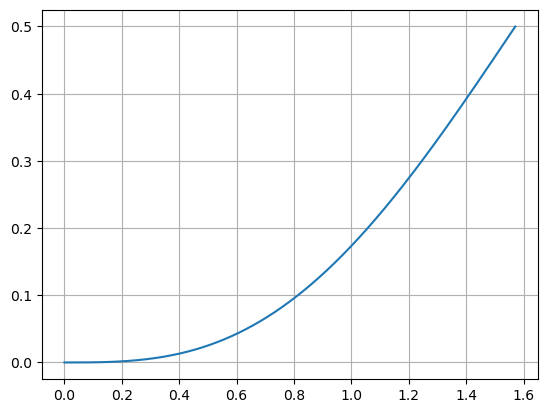

In [269]:
def area_prob(theta):
    return (2*theta - np.sin(2*theta))/(2*np.pi)

thetas = np.linspace(0, np.pi/2, 1000)

plt.plot(thetas, area_prob(thetas))
plt.grid();plt.show()